In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\MFEG\\dataprocessing\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Concatenate

def ince_block(inputs, filters, strides=1):
    x1 = Conv1D(filters, 3, strides=strides, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv1D(filters, 5, strides=1, padding='same')(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv1D(filters, 9, strides=1, padding='same')(inputs)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv1D(filters, 17, strides=1, padding='same')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    x = Concatenate()([x1, x2, x3, x4])
    x = Activation('relu')(x)
    return x


In [6]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, Multiply
def se_block(input_tensor, reduction_ratio=16):
  channels = input_tensor.shape[-1]
  x = GlobalAveragePooling1D()(input_tensor)
  x = Reshape((1, channels))(x)
  x = Dense(channels // reduction_ratio, activation='relu', use_bias=False)(x)
  x = Dense(channels, activation='sigmoid', use_bias=False)(x)
  x = Multiply()([input_tensor, x])
  return x


In [7]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, GRU
from tensorflow.keras.models import Model
import tensorflow as tf

def residual_shrinkage_block_1d(incoming, nb_blocks, out_channels, downsample=False, downsample_strides=2, activation='relu', kernel_size=31,batch_norm=True, bias=True, weights_init='variance_scaling', bias_init='zeros', regularizer='l2', weight_decay=0.0001, trainable=True, name="ResidualShrinkageBlock"):
  residual = incoming
  in_channels = incoming.shape[-1]
  for i in range(nb_blocks):
    identity = residual
    if downsample:
      downsample_strides = 2
    else:
      downsample_strides = 1
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    # Thresholding
    abs_mean = tf.reduce_mean(tf.abs(residual), axis=1, keepdims=True)
    scales = Dense(out_channels // 4, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(abs_mean)
    scales = BatchNormalization()(scales)
    scales = Activation('relu')(scales)
    scales = Dense(out_channels, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(scales)
    scales = tf.sigmoid(scales)
    thres = abs_mean * scales
    residual = tf.sign(residual) * tf.maximum(tf.abs(residual) - thres, 0)
    
    # Downsampling and projection
    if downsample_strides > 1:
      identity = Conv1D(out_channels, 1, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    if in_channels != out_channels or downsample:
      identity = Conv1D(out_channels, 1, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    residual = residual + identity

  return residual


In [8]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add

def res_block31_dilated_causal(inputs, filters, kernel_size=31, dilation_rate=2,strides=1):
  shortcut = inputs
  # 使用扩张卷积和因果卷积
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(x)
  x = BatchNormalization()(x)
  
  # 调整shortcut路径以匹配主路径的维度
  if inputs.shape[-1] != filters:
    shortcut = Conv1D(filters, 1, strides=strides, padding='causal')(inputs)  
    shortcut = BatchNormalization()(shortcut)
  
  x = Add()([x, shortcut])
  x = Activation('relu')(x)
  return x


In [9]:
def res_block31(inputs, filters, kernel_size=31, strides=1):
    shortcut = inputs
    
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
def resxnet(num_classes=4):
    input_1 = Input(shape=(4500,1))
    x = Conv1D(64, 12, strides=2, padding='same')(input_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ince_block(x,64)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, out_channels=64, downsample=True)
    x = res_block31_dilated_causal(x, 32,31,2,1)
    x = se_block(x,32)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, kernel_size=16,out_channels=32, downsample=True)
    x = res_block31_dilated_causal(x, 64,16,2,1)
    x = se_block(x,64)
    x = res_block31(x, 128, kernel_size=9,strides=2)
    x = res_block31(x, 256, kernel_size=6,strides=2)
    x = res_block31(x, 512, kernel_size=3,strides=2)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=input_1, outputs=x)
    return model


In [11]:
model = resxnet()
model.summary()
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=512, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 64)     832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

In [13]:
evaluate_model(model,X_test,y_test)

Precision: 0.8036229584660078
Recall: 0.6235331472367514
F1 Score: 0.6643102350287847
Accuracy: 0.826226870474658
Class 1 - Precision: 0.7937219730941704, Recall: 0.7797356828193832, F1 Score: 0.7866666666666665
Class 2 - Precision: 0.8032432432432433, Recall: 0.9900066622251832, F1 Score: 0.8868994330050731
Class 3 - Precision: 0.9508599508599509, Recall: 0.524390243902439, F1 Score: 0.6759825327510917
Class 4 - Precision: 0.6666666666666666, Recall: 0.2, F1 Score: 0.30769230769230765
Class 1 Accuracy: 0.9613837489943685
Class 2 Accuracy: 0.8475462590506838
Class 3 Accuracy: 0.8507642799678198
Class 4 Accuracy: 0.9927594529364441


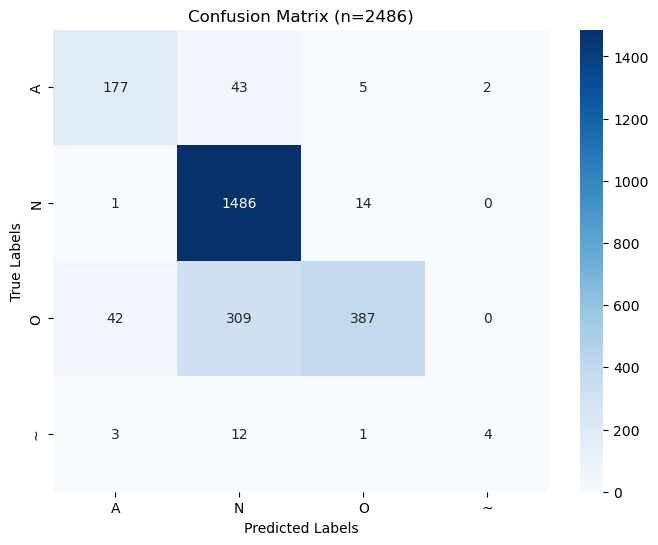

In [14]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])